## Notebook to create a regional rainfall-runoff model using an LSTM network for CAMELS CH Dataset

*xLSTM Architecture with tanh activation on ct/nt;*
*Only 229 catchments belonging to CH from CAMELS CH*

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. The code allows for the creation of single-basin models, but it is conceptualized to create 
regional models. The code is intended as an intial introduction to the topic, in which we prioritized interpretability
over modularity. The model generated in this code makes use of the CAMELS CH Datset [2]

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

**Authors:**
- Eduardo Acuna Espinoza (eduardo.espinoza@kit.edu)
- Ralf Loritz
- Manuel Álvarez Chaves

**Adaptations:**
- Sanika Baste (sanika.baste@kit.edu)

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

[2]: Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., and Fenicia, F.: CAMELS-CH: hydro-meteorological time series and landscape attributes for 331 catchments in hydrologic Switzerland, Earth Syst. Sci. Data, 15, 5755–5784, https://doi.org/10.5194/essd-15-5755-2023, 2023.

In [1]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append("../aux_functions")
sys.path.append("../datasetzoo")
sys.path.append("../modelzoo")

# Import classes and functions from other files
from functions_training import nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

# Import dataset to use
from camelsch import CAMELS_CH

# Import model
from cudalstm import CudaLSTM
# from slstmcell import sLSTM

# ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Part 1. Initialize information

In [2]:
# Define experiment name
experiment_name = "LSTM_CAMELS_CH_slstm_tanh_jit"

# paths to access the information
path_entities = "../../data/basin_id/basins_camels_ch_229_onlyCH.txt"
path_data = "../../data/CAMELS_CH"

# dynamic forcings and target
dynamic_input = ['precipitation(mm/d)', 'temperature_min(degC)', 'temperature_max(degC)', 'rel_sun_dur(%)', 'swe(mm)']
target = ['discharge_spec(mm/d)']

# static attributes that will be used
static_input = ['area',
                'elev_mean',
                'slope_mean',
                'sand_perc',
                'silt_perc',
                'clay_perc',
                'porosity',
                'conductivity',
                'glac_area',
                'dwood_perc',
                'ewood_perc',
                'crop_perc',
                'urban_perc',
                'reservoir_cap',
                'p_mean',
                'pet_mean',
                'p_seasonality',
                'frac_snow',
                'high_prec_freq',
                'low_prec_freq',
                'high_prec_dur',
                'low_prec_dur']

# time periods
training_period = ['1995-10-01','2005-09-30']
validation_period = ['2005-10-01','2010-09-30']
testing_period = ['2010-10-01','2015-09-30']

model_hyper_parameters = {
    "input_size_lstm": len(dynamic_input) + len(static_input),
    "no_of_layers":1,  
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size_training":256,
    "batch_size_validation":512,
    "batch_size_testing":(pd.to_datetime(testing_period[1])-pd.to_datetime(testing_period[0])).days+1,
    "no_of_epochs": 30,             
    "drop_out_rate": 0.4, 
    "learning_rate": 0.005,
    "adapt_learning_rate_epoch": 5,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3,
    "validate_every": 1,
    "validate_n_random_basins": -1
    }

# device to train the model
running_device = "gpu" #cpu or gpu

# define random seed
seed = 17

# colorblind friendly palette for plotting
color_palette = {"observed": "#1f78b4","simulated": "#ff7f00"}

In [3]:
# Create folder to store the results
path_save_folder = "../results/"+experiment_name
create_folder(folder_path=path_save_folder)

Folder '../results/LSTM_CAMELS_CH_slstm_tanh_jit' already exists.


In [4]:
# check if model will be run in gpu or cpu and define device
if running_device == "gpu":
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == "cpu":
    device = "cpu"

Tesla V100-SXM2-32GB


Part 2. Create dataset and dataloader for training

In [5]:
# Dataset training
training_dataset = CAMELS_CH(dynamic_input= dynamic_input,
                             target= target, 
                             sequence_length= model_hyper_parameters["seq_length"],
                             time_period= training_period,
                             path_data= path_data,
                             path_entities= path_entities,
                             static_input= static_input,
                             check_NaN= True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()

In [6]:
# Dataloader training
train_loader = DataLoader(dataset = training_dataset, 
                          batch_size = model_hyper_parameters["batch_size_training"],
                          shuffle = True,
                          drop_last = True)

print("Batches in training: ", len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample["x_lstm"].shape} | y_obs: {sample["y_obs"].shape} | basin_std: {sample["basin_std"].shape}')

Batches in training:  1382
x_lstm: torch.Size([256, 365, 27]) | y_obs: torch.Size([256, 1, 1]) | basin_std: torch.Size([256, 1, 1])


Part 3. Create dataset for validation

In [7]:
# We will create an individual dataset per basin. This will give us more flexibility
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
validation_dataset = {}

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= validation_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity]= dataset

Part 4.0: sLSTM class definition with jit

In [8]:
set_random_seed(seed=seed)

In [9]:
import torch
import torch.nn as nn
from collections import defaultdict
from typing import Optional

class sLSTMCell(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(sLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Parameters for input, forget, and output gates
        self.w_i = nn.Parameter(torch.FloatTensor(hidden_size, input_size))
        self.w_f = nn.Parameter(torch.FloatTensor(hidden_size, input_size))
        self.w_o = nn.Parameter(torch.FloatTensor(hidden_size, input_size))
        self.w_z = nn.Parameter(torch.FloatTensor(hidden_size, input_size))

        self.r_i = nn.Parameter(
            torch.FloatTensor(hidden_size, hidden_size)
        )
        self.r_f = nn.Parameter(
            torch.FloatTensor(hidden_size, hidden_size)
        )
        self.r_o = nn.Parameter(
            torch.FloatTensor(hidden_size, hidden_size)
        )
        self.r_z = nn.Parameter(
            torch.FloatTensor(hidden_size, hidden_size)
        )

        self.b_i = nn.Parameter(torch.FloatTensor(self.r_i.shape[0]))
        self.b_f = nn.Parameter(torch.FloatTensor(self.r_f.shape[0]))
        self.b_o = nn.Parameter(torch.FloatTensor(self.r_o.shape[0]))
        self.b_z = nn.Parameter(torch.FloatTensor(self.r_z.shape[0]))

        # Initialize parameters
        self.reset_parameters()

        # some activations
        self.softplus = nn.Softplus

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.w_i)
        nn.init.xavier_uniform_(self.w_f)
        nn.init.xavier_uniform_(self.w_o)
        nn.init.xavier_uniform_(self.w_z)

        nn.init.orthogonal_(self.r_i)
        nn.init.orthogonal_(self.r_f)
        nn.init.orthogonal_(self.r_o)
        nn.init.orthogonal_(self.r_z)

        nn.init.zeros_(self.b_i)
        nn.init.zeros_(self.b_f)
        nn.init.zeros_(self.b_o)
        nn.init.zeros_(self.b_z)

    def forward(self,
                x,
                h_prev: torch.Tensor,
                c_prev: torch.Tensor,
                n_prev: torch.Tensor,
                m_prev: torch.Tensor):

        i_tilda = (
            torch.matmul(x, self.w_i.T)
            + torch.matmul(h_prev, self.r_i.T)
            + self.b_i
        )
        f_tilda = (
            torch.matmul(x, self.w_f.T)
            + torch.matmul(h_prev, self.r_f.T)
            + self.b_f
        )
        o_tilda = (
            torch.matmul(x, self.w_o.T)
            + torch.matmul(h_prev, self.r_o.T)
            + self.b_o
        )
        z_tilda = (
            torch.matmul(x, self.w_z.T)
            + torch.matmul(h_prev, self.r_z.T)
            + self.b_z
        )
        
        i_t = torch.exp(i_tilda)
        f_t = torch.exp(
            f_tilda
        )  # Chosen exponential activation

        # Stabilizer state update
        m_t = torch.max(torch.log(f_t) + m_prev, torch.log(i_t))

        # Stabilized gates
        i_prime = torch.exp(torch.log(i_t) - m_t) #i_t_prime
        f_prime = torch.exp(torch.log(f_t) + m_prev - m_t) #f_t_prime

        c_t = f_prime * c_prev + i_prime * torch.tanh(z_tilda)
        n_t = f_prime * n_prev + i_prime
        
        c_hat = c_t / n_t
        h_t = torch.sigmoid(o_tilda) * torch.tanh(c_hat)

        # return h_t, (h_t, c_t, n_t, m_t)
        return {'h_t': h_t, 'c_t': c_t, 'n_t': n_t, 'm_t': m_t,
                 'i_tilda': i_tilda, 'f_tilda': f_tilda, 'o_tilda': o_tilda, 'z_tilda': z_tilda,
                 'i_prime': i_prime, 'f_prime': f_prime}

scripted_sLSTMCell = torch.jit.script(sLSTMCell(input_size=torch.tensor(model_hyper_parameters['input_size_lstm']),
                                        hidden_size=torch.tensor(model_hyper_parameters['hidden_size'])))
# print(scripted_sLSTMCell.code)

class sLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size:int, num_layers: int, drop_out_rate: int):
        super(sLSTM, self).__init__()
        # self.cell = sLSTMCell(input_size, hidden_size)
        self.cell = scripted_sLSTMCell
        self.dropout = nn.Dropout(drop_out_rate)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x:torch.Tensor,
                        h_prev:Optional[torch.Tensor]=None,
                        c_prev:Optional[torch.Tensor]=None,
                        n_prev:Optional[torch.Tensor]=None,
                        m_prev:Optional[torch.Tensor]=None):

        batch_size, seq_len, _ = x.size()
        
        if h_prev is None:
            h_prev = torch.zeros(batch_size, self.cell.hidden_size).to(x.device)
        if c_prev is None:
            c_prev = torch.zeros(batch_size, self.cell.hidden_size).to(x.device)
        if n_prev is None:
            n_prev = torch.zeros(batch_size, self.cell.hidden_size).to(x.device)
        if m_prev is None:
            m_prev = torch.zeros(batch_size, self.cell.hidden_size).to(x.device)
    
        current_states = (h_prev, c_prev, n_prev, m_prev)
        
        output = {'h_t': [], 'c_t': [], 'n_t': [], 'm_t': [],
                 'i_tilda': [], 'f_tilda': [], 'o_tilda': [], 'z_tilda': [],
                 'i_prime': [], 'f_prime': []}
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            h_prev, c_prev, n_prev, m_prev = current_states

            cell_output = self.cell(x_t, h_prev=h_prev, c_prev=c_prev, n_prev=n_prev, m_prev=m_prev)
            
            current_states = (cell_output['h_t'], cell_output['c_t'], cell_output['n_t'], cell_output['m_t'])
            
            for key, cell_out in cell_output.items():
                output[key].append(cell_out)
        
        pred = {key: torch.stack(val, 1) for key, val in output.items()}
        pred.update({"y_hat": self.linear(self.dropout(pred['h_t'][:,-1, :]))})
        
        return pred

scripted_sLSTM = torch.jit.script(sLSTM(input_size=model_hyper_parameters['input_size_lstm'],
                                        hidden_size=model_hyper_parameters['hidden_size'],
                                        num_layers=model_hyper_parameters['no_of_layers'],
                                        drop_out_rate=model_hyper_parameters['drop_out_rate']))
# print(scripted_sLSTM.code)

Part 4. Train LSTM

In [ ]:
# construct model
lstm_model = scripted_sLSTM.to(device)

# in case of training a previously trained model further
path_save_folder__ = "../results/LSTM_CAMELS_CH_slstm_tanh_jit"
lstm_model.load_state_dict(torch.load(path_save_folder__ + "/epoch_23", map_location=device))

# optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])
    
# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=model_hyper_parameters["adapt_learning_rate_epoch"],
                                            gamma=model_hyper_parameters["adapt_gamma_learning_rate"])
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 11], gamma=0.5)
# scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=0,
#                                                        threshold=0.01, threshold_mode='abs', cooldown=0,
#                                                        min_lr=0, eps=1e-08, verbose='deprecated')

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
lstm_model.cell.b_f.data[:]=model_hyper_parameters["set_forget_gate"]

training_time = time.time()
# Loop through the different epochs
for epoch in range(24, model_hyper_parameters["no_of_epochs"]+1):
    
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    lstm_model.train()
    for sample in train_loader: 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        pred  = lstm_model(sample["x_lstm"].to(device)) # forward call

        # bla1=torch.isnan(sample["x_lstm"]).any()
        # bla2=torch.isnan(pred["y_hat"]).any()
        # bla3=torch.isnan(sample["y_obs"]).any()
        # bla4=torch.isnan(sample["basin_std"]).any()
        # print(f'{bla1}|{bla2}|{bla3}|{bla4}')
        
        loss = nse_basin_averaged(y_sim=pred["y_hat"], 
                                  y_obs=sample["y_obs"].to(device), 
                                  per_basin_target_std=sample["basin_std"].to(device))
        # print(loss)

        loss.backward() # backpropagates
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), 1) #clip gradients
        optimizer.step() #update weights
        total_loss.append(loss.item())
        
        # remove from cuda
        del sample["x_lstm"], sample["y_obs"], sample["basin_std"], pred
        torch.cuda.empty_cache()
        
    #training report  
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'
    
    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % model_hyper_parameters["validate_every"] == 0:
        lstm_model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if model_hyper_parameters["validate_n_random_basins"] <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, model_hyper_parameters["validate_n_random_basins"])
            
            # go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(dataset=validation_dataset[basin], 
                                    batch_size=model_hyper_parameters["batch_size_validation"], 
                                    shuffle=False, 
                                    drop_last = False)
                
                df_ts = pd.DataFrame()
                for sample in loader:
                    pred  = lstm_model(sample["x_lstm"].to(device)) 
                    # backtransformed information
                    y_sim = pred["y_hat"]* validation_dataset[basin].scaler["y_std"].to(device) +\
                        validation_dataset[basin].scaler["y_mean"].to(device)

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                       "y_sim": y_sim.flatten().cpu().detach()}, 
                                      index=pd.to_datetime(sample["date"]))

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del pred, y_sim
                    torch.cuda.empty_cache()       
                
                validation_results[basin] = df_ts
                 
            #average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| NSE validation: {"%.3f "% (loss_validation)}'

    
    # save model after every epoch
    path_saved_model = path_save_folder+"/epoch_" + str(epoch)
    torch.save(lstm_model.state_dict(), path_saved_model)
            
    # print epoch report
    report += f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | LR:{"%.5f "% (optimizer.param_groups[0]["lr"])}'
    print(report)
    write_report(file_path=path_save_folder+"/run_progress.txt", text=report)
    # modify learning rate
    # scheduler.step()

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(file_path=path_save_folder+"/run_progress.txt", text=report)   

/pfs/data5/home/kit/iwu/si3685/Hy2DL/Hy2DL/experiments/../aux_functions/functions_evaluation.py:49: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(loss) if average else np.asarray(loss)


Epoch: 24 | Loss training: nan | NSE validation: nan | Epoch time: 745.5  s | LR:0.00125 


/pfs/data5/home/kit/iwu/si3685/Hy2DL/Hy2DL/experiments/../aux_functions/functions_evaluation.py:49: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(loss) if average else np.asarray(loss)


Epoch: 25 | Loss training: nan | NSE validation: nan | Epoch time: 728.2  s | LR:0.00125 


/pfs/data5/home/kit/iwu/si3685/Hy2DL/Hy2DL/experiments/../aux_functions/functions_evaluation.py:49: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(loss) if average else np.asarray(loss)


Epoch: 26 | Loss training: nan | NSE validation: nan | Epoch time: 732.5  s | LR:0.00125 


Part 5. Test LSTM

In [10]:
# In case I already trained an LSTM I can re-construct the model
lstm_model = sLSTM(model_hyper_parameters['input_size_lstm'],
                  model_hyper_parameters['hidden_size'],
                  model_hyper_parameters['no_of_layers'],
                  model_hyper_parameters['drop_out_rate']).to(device)
lstm_model.load_state_dict(torch.load(path_save_folder + "/epoch_22", map_location=device))

<All keys matched successfully>

In [11]:
# We will create an individual dataset per basin. This will give us more flexibility
#path_entities = "../../data/basin_id/basins_camels_gb_lees.txt"
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
# entities_ids = ['2346', '2303', '2494']
testing_dataset = {}

# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= testing_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity]= dataset

In [12]:
lstm_model.eval()
inspect_results_states = {}
inspect_results = {}
create_folder(folder_path=path_save_folder+"/inspect_results_states")

test_n_random_basins = -1
if test_n_random_basins <= 0:
    test_basin_ids = testing_dataset.keys()
else:
    keys = list(testing_dataset.keys())
    test_basin_ids = random.sample(keys, test_n_random_basins)

with torch.no_grad():
    for basin in test_basin_ids:
        loader = DataLoader(dataset = testing_dataset[basin], 
                            batch_size = model_hyper_parameters["batch_size_testing"], 
                            shuffle = False, 
                            drop_last = False) 
        
        df_ts = pd.DataFrame()
        inspectmodel_output = []

        for sample in loader:
            pred  = lstm_model(sample["x_lstm"].to(device)) 
            # backtransformed information
            y_sim = pred["y_hat"]* dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            # _output = {"h_t": pred["h_t"].cpu().detach(),
            #             "c_t": pred["c_t"].cpu().detach(),
            #             "n_t": pred["n_t"].cpu().detach(),
            #             "m_t": pred["m_t"].cpu().detach(),
            #             "i_tilda":pred["i_tilda"].cpu().detach(),
            #             "f_tilda":pred["f_tilda"].cpu().detach(),
            #             "o_tilda":pred["o_tilda"].cpu().detach(),
            #             "z_tilda":pred["z_tilda"].cpu().detach(),
            #             "i_prime":pred["i_prime"].cpu().detach(),
            #             "f_prime":pred["f_prime"].cpu().detach(),
            #             "y_hat":y_sim.cpu().detach()}
            # inspectmodel_output.append(_output)

            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                               "y_hat": pred["y_hat"].flatten().cpu().detach(),
                                "y_sim": y_sim.flatten().cpu().detach()}, 
                                index=pd.to_datetime(sample["date"]))
            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del pred, y_sim
            torch.cuda.empty_cache()       
        
        # inspect_results_states[basin] = inspectmodel_output
        inspect_results[basin] = df_ts

        # Save results as a pickle file
        # with open(path_save_folder+"/inspect_results_states/"+str(basin)+".pickle", "wb") as f_:
        #    pickle.dump(inspectmodel_output, f_)
            
        del inspectmodel_output, df_ts
        print('Testing using CustomLSTM complete for ' + str(basin))

# Save results as a pickle file
with open(path_save_folder+"/inspect_results.pickle", "wb") as f:
    pickle.dump(inspect_results, f)

Folder '../results/LSTM_CAMELS_CH_slstm_tanh_jit/inspect_results_states' already exists.
Testing using CustomLSTM complete for 2004
Testing using CustomLSTM complete for 2007
Testing using CustomLSTM complete for 2009
Testing using CustomLSTM complete for 2011
Testing using CustomLSTM complete for 2014
Testing using CustomLSTM complete for 2016
Testing using CustomLSTM complete for 2017
Testing using CustomLSTM complete for 2018
Testing using CustomLSTM complete for 2019
Testing using CustomLSTM complete for 2020
Testing using CustomLSTM complete for 2021
Testing using CustomLSTM complete for 2022
Testing using CustomLSTM complete for 2023
Testing using CustomLSTM complete for 2024
Testing using CustomLSTM complete for 2025
Testing using CustomLSTM complete for 2026
Testing using CustomLSTM complete for 2027
Testing using CustomLSTM complete for 2028
Testing using CustomLSTM complete for 2029
Testing using CustomLSTM complete for 2030
Testing using CustomLSTM complete for 2031
Testing 

Part 6. Initial analysis

In [13]:
# In case we already ran our model
#with open(path_save_folder+"/test_results.pickle", "rb") as f:
#    test_results = pickle.load(f)

In [14]:
# Loss testing
loss_testing = nse(df_results=inspect_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": test_basin_ids, "NSE": np.round(loss_testing,3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(path_save_folder+"/NSE.csv", index=True, header=True)

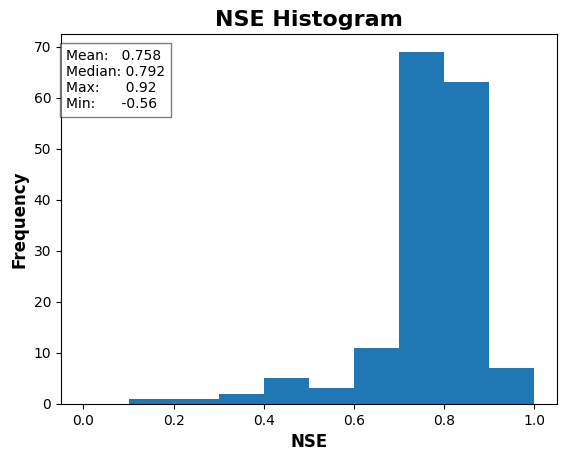

In [15]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.3f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.3f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
#plt.savefig(save_folder+"/NSE_LSTM_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [16]:
# calculating NSE for prevah modeled runoff

from pathlib import Path
entities_ids = np.loadtxt(path_entities, dtype='str').tolist()
prevah_results = {}
start_date = pd.to_datetime(testing_period[0],format="%Y-%m-%d")
end_date = pd.to_datetime(testing_period[1],format="%Y-%m-%d")
prevah_q = ['discharge_spec_sim(mm/d)']
target = ['discharge_spec(mm/d)']
loss_testing_prevah = pd.DataFrame(index=entities_ids, columns=['PREVAH_NSE'])

for id in entities_ids:
    
    # load prevah simulated discharge time series
    path_timeseries = Path(path_data) / 'timeseries' / 'simulation_based' / f'CAMELS_CH_sim_based_{id}.csv'
    df = pd.read_csv(path_timeseries)
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
    y_prevah_sim = df.loc[start_date:end_date, prevah_q]
    # print(y_prevah_sim)
    
    # load observed discharge time series
    path_timeseries_obs = Path(path_data) / 'timeseries' / 'observation_based' / f'CAMELS_CH_obs_based_{id}.csv'
    df_obs = pd.read_csv(path_timeseries_obs)
    df_obs = df_obs.set_index('date')
    df_obs.index = pd.to_datetime(df_obs.index, format="%Y-%m-%d")
    y_obs = df_obs.loc[start_date:end_date, target]
    
    # Read values
    y_sim = y_prevah_sim.values 
    y_obs = y_obs.values
    
    # Mask values based on NaN from y_sim (this occurs in validation and testing if there are NaN in the inputs)
    mask_y_sim = ~np.isnan(y_sim)
    y_sim = y_sim[mask_y_sim]
    y_obs = y_obs[mask_y_sim]

    # Mask values based on NaN from y_obs (this occurs in validation and testing if there are NaN in the output)
    mask_y_obs = ~np.isnan(y_obs)
    y_sim = y_sim[mask_y_obs]
    y_obs = y_obs[mask_y_obs]

    # Calculate NSE
    if y_sim.size > 1 and y_obs.size > 1:
        loss_testing_prevah.loc[id]['PREVAH_NSE'] = (1.0 - np.sum((y_sim - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2))
    else:
        loss_testing_prevah.loc[id]['PREVAH_NSE'] = (np.nan)

In [17]:
# importing LSTM Cell with tanh activation testing results
lstmCell_NSE_path = "../results/LSTM_CAMELS_CH_customlstm_tanh_229CH/NSE_LSTMCell_tanh.csv"
df_NSE_LSTMCell_tanh = pd.read_csv(lstmCell_NSE_path)

# importing GRU Cell testing results
gruCell_NSE_path = "../results/LSTM_CAMELS_CH_gru_229CH/NSE_gruCell.csv"
df_NSE_gruCell = pd.read_csv(gruCell_NSE_path)

# importing transformer (with embedding) testing results
transformer_NSE_path = "../results/LSTM_CAMELS_CH_transformers_we_229CH/NSE_transformer_we.csv"
df_NSE_transformer = pd.read_csv(transformer_NSE_path)

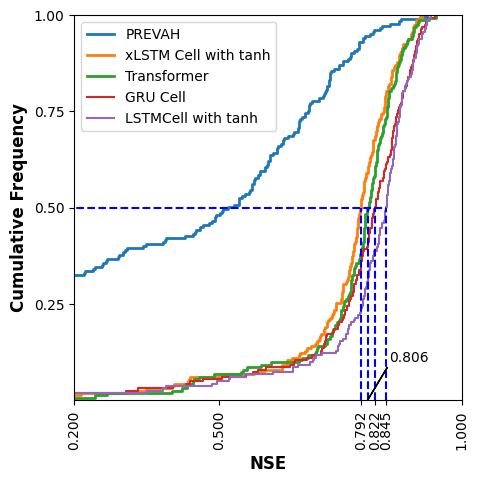

In [29]:
# Plot the CDF
mask_LSTM = df_NSE['NSE'].notnull()
NSE_LSTM = df_NSE['NSE'][mask_LSTM]
mask_PREVAH = loss_testing_prevah['PREVAH_NSE'].notnull()
NSE_PREVAH = loss_testing_prevah['PREVAH_NSE'][mask_PREVAH]
mask_NSELstmCell = df_NSE_LSTMCell_tanh['NSE'].notnull()
NSELstmCell = df_NSE_LSTMCell_tanh['NSE'][mask_NSELstmCell]
mask_GRUCell = df_NSE_gruCell['NSE'].notnull()
NSEGRUCell = df_NSE_gruCell['NSE'][mask_GRUCell]
mask_transformer = df_NSE_transformer['NSE'].notnull()
NSETransformer = df_NSE_transformer['NSE'][mask_transformer]

plt.subplots(figsize=(5, 5))
plt.ecdf(NSE_PREVAH.astype(float), label='PREVAH', linewidth=2)
plt.ecdf(NSE_LSTM, label='xLSTM Cell with tanh', linewidth=2)
plt.ecdf(NSETransformer, label='Transformer', linewidth=2)
plt.ecdf(NSEGRUCell, label='GRU Cell')
plt.ecdf(NSELstmCell, label='LSTMCell with tanh')
plt.plot([0.792, 0.792], [0.0, 0.5], color='b', linestyle='--')
plt.plot([0.806, 0.806], [0.0, 0.5], color='b', linestyle='--')
plt.plot([0.822, 0.822], [0.0, 0.5], color='b', linestyle='--')
plt.plot([0.845, 0.845], [0.0, 0.5], color='b', linestyle='--')
plt.plot([0.0, 0.845], [0.5, 0.5], color='b', linestyle='--')
#plt.savefig(save_folder+'/NSE_LSTM_cdf.png', bbox_inches='tight', pad_inches=0)

# Add NSE statistics to the plot
# plt.text(0.05, 0.6, f'LSTM:\nMean: {"%.2f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.2f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
#          transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
# min = loss_testing_prevah['PREVAH_NSE'].min()
# mean = loss_testing_prevah['PREVAH_NSE'].mean()
# max = loss_testing_prevah['PREVAH_NSE'].max()
# med = loss_testing_prevah['PREVAH_NSE'].median()
# plt.text(0.35, 0.6, f'PREVAH:\nMean: {"%.2f" %mean}\nMedian: {"%.2f" %med}\nMax: {"%.2f" %max}\nMin: {"%.2f" %min}',
#          transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.xlim([0.2, 1])
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Frequency', fontsize=12, fontweight='bold')
#plt.title('Comparison of Performance', fontsize=16, fontweight='bold')
plt.xticks([0.2, 0.5, 0.792, 0.822, 0.845, 1.0], rotation=90)
plt.yticks(ticks=[0.25, 0.5, 0.75, 1])
plt.legend(loc='best')
plt.annotate("0.806", [0.806, 0.0], xytext=[0.850, 0.1], xycoords='data', textcoords=None, arrowprops={'width': 0.2, 'headwidth': 0.2})
plt.savefig(path_save_folder+'/NSE_LSTM_CDF_notitle3.png', bbox_inches='tight', pad_inches=0)
plt.show()

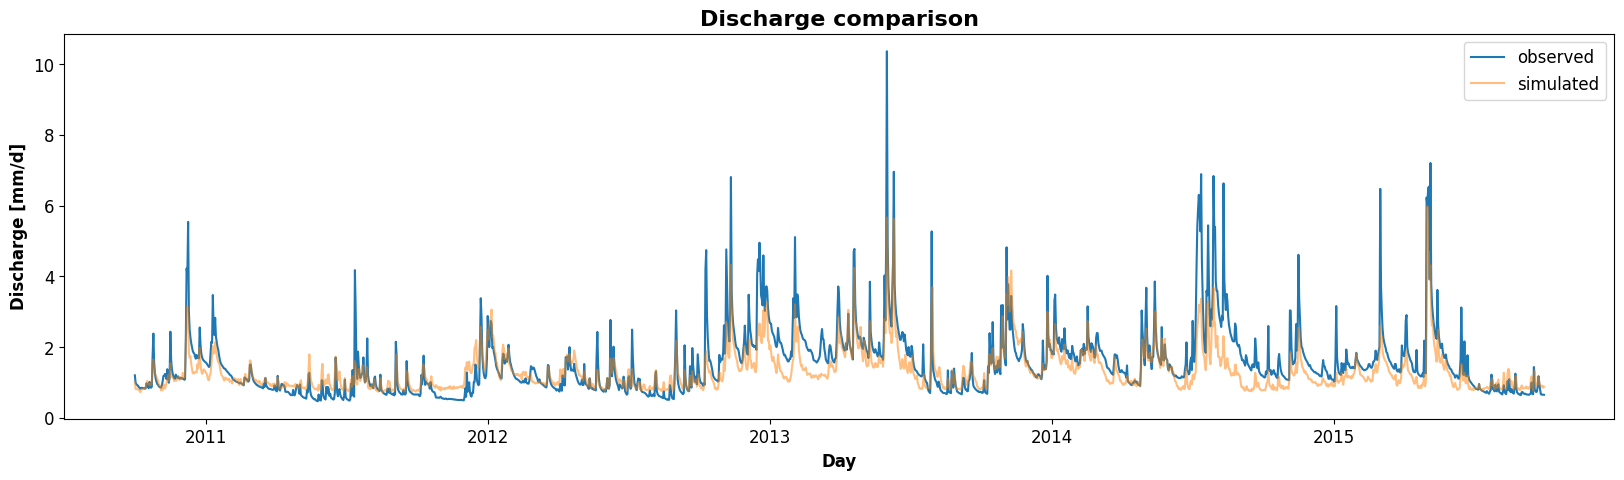

In [30]:
# Plot simulated and observed discharges
basin_to_analyze = "2500"

plt.plot(inspect_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(inspect_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Day", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Discharge comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()
#plt.savefig(save_folder+"/Model_Comparison.png", bbox_inches="tight", pad_inches=0)

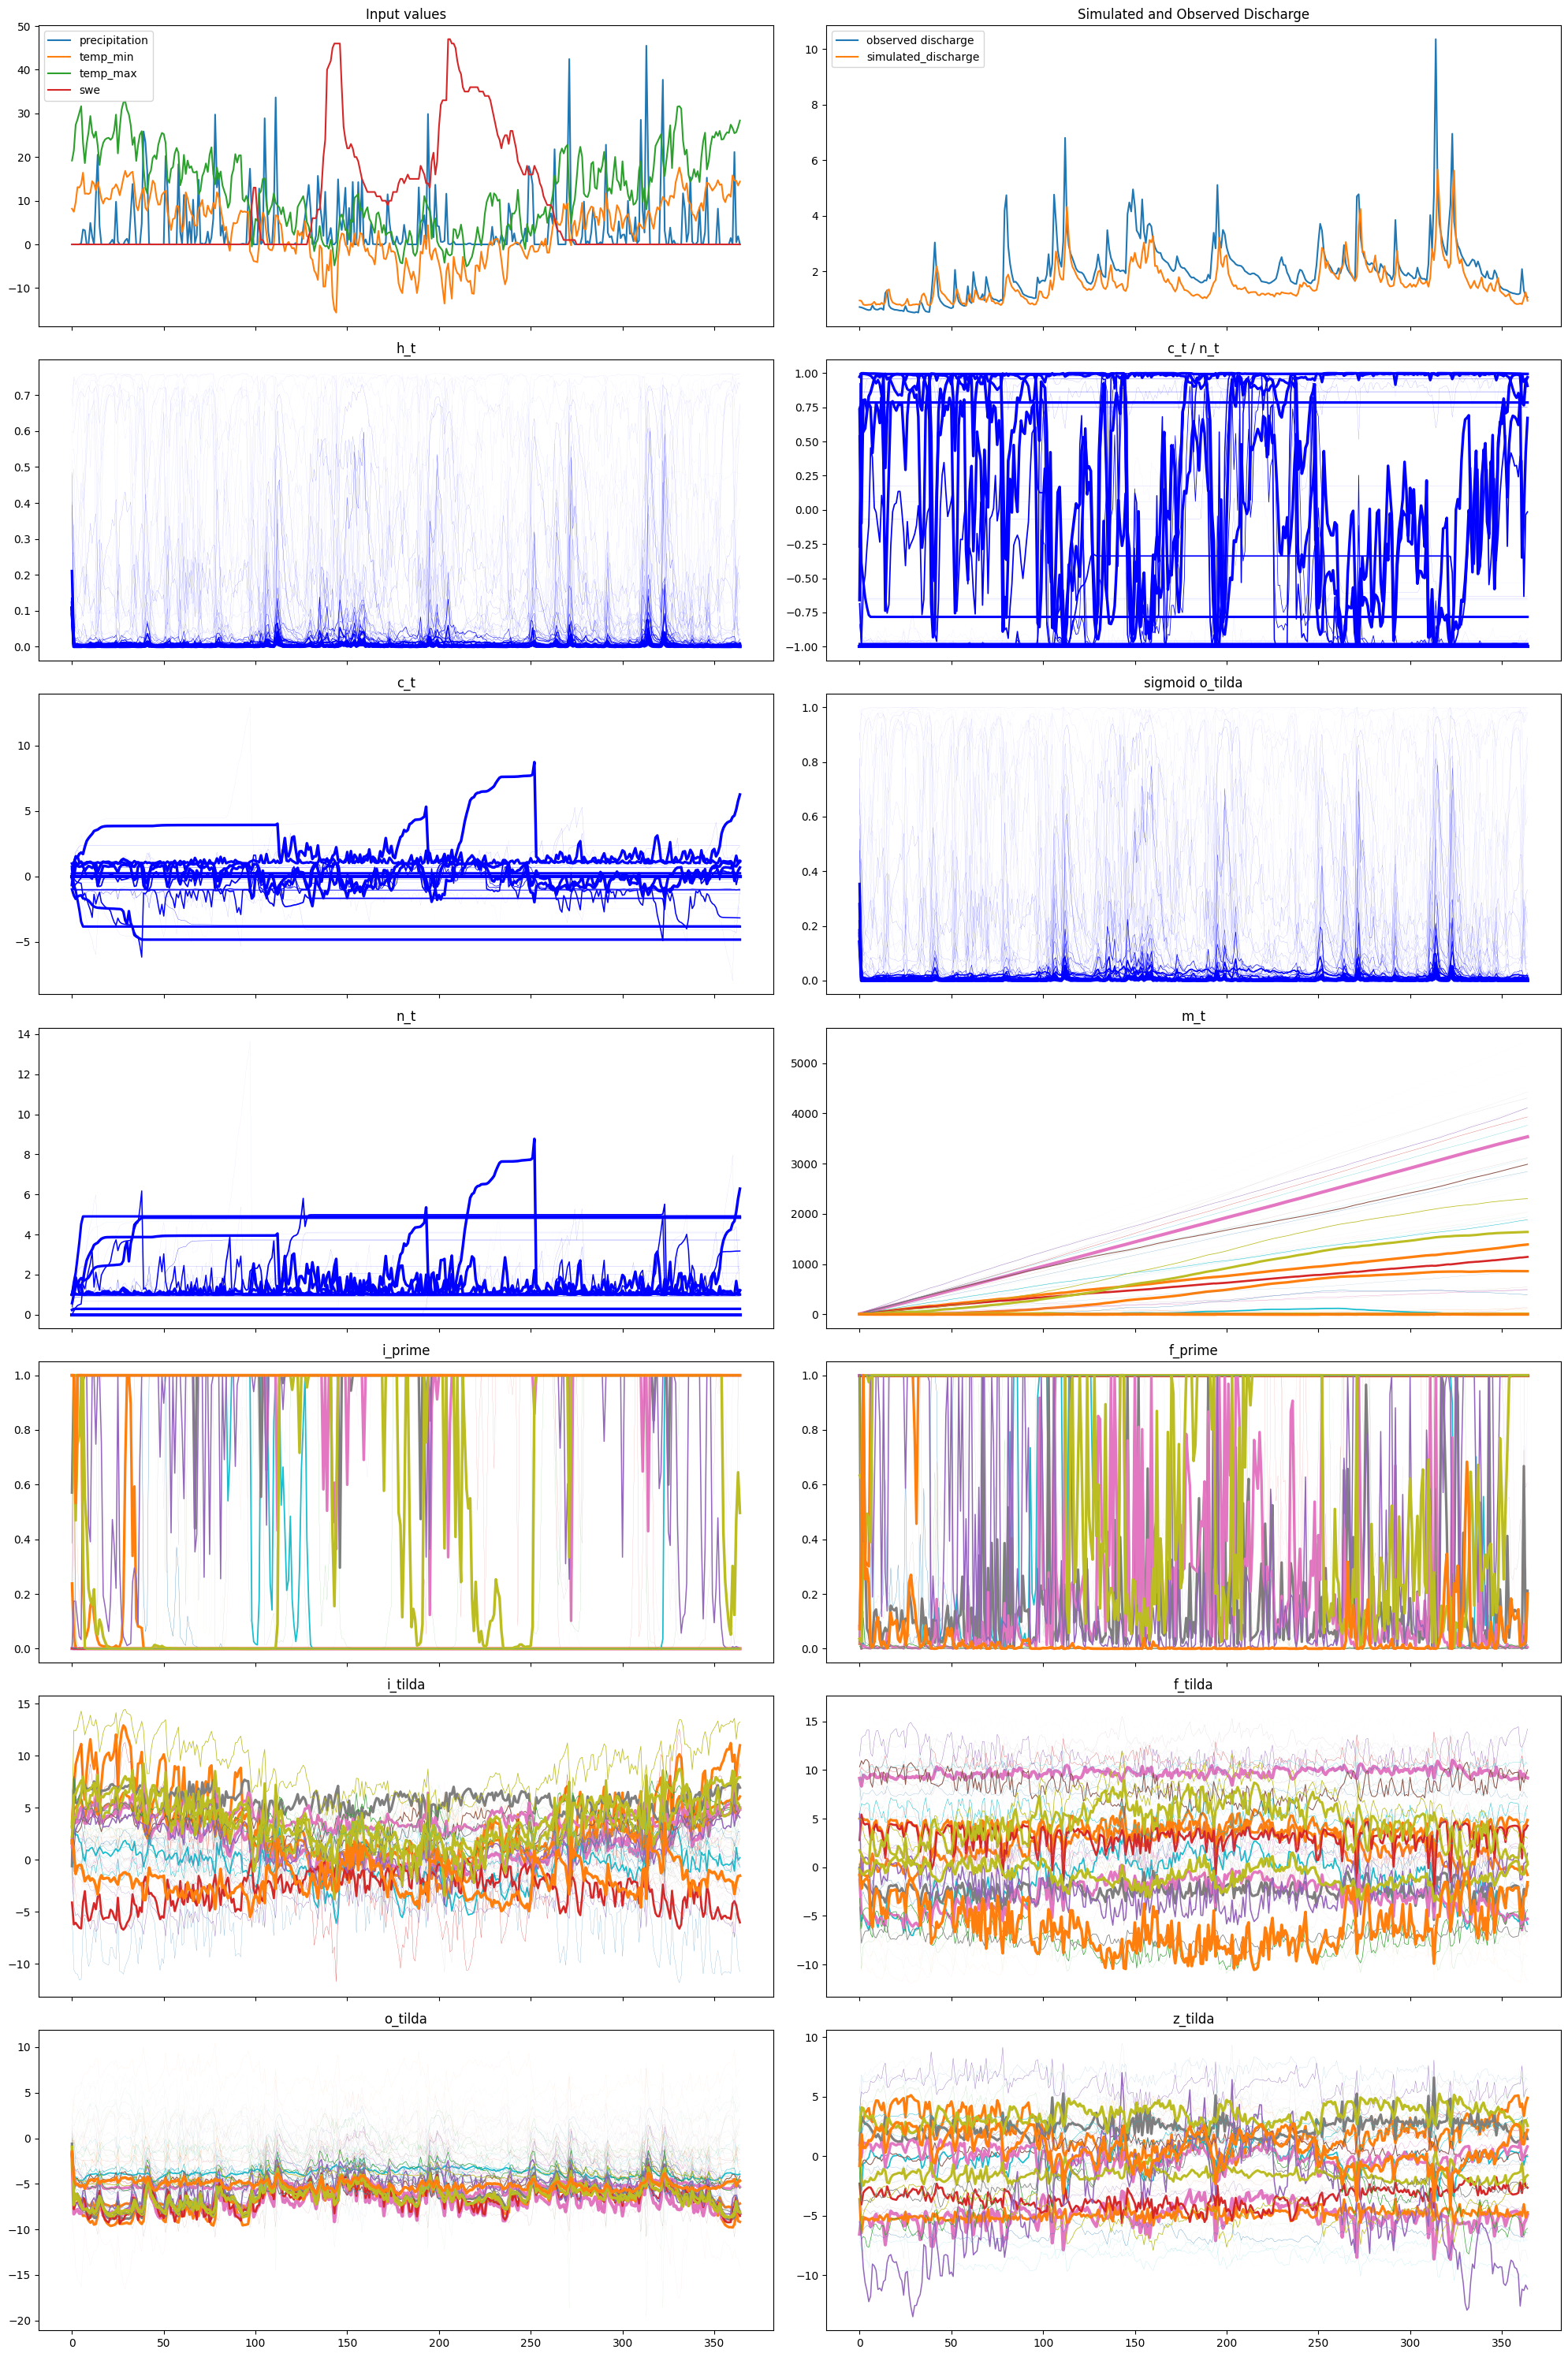

In [31]:
inspectmodel_states = inspect_results_states[basin_to_analyze]
weights_linear, _ = lstm_model.linear.state_dict().items()

f, ax = plt.subplots(7, 2, figsize=(20, 30), sharex=True)
idx = 1024
sl = model_hyper_parameters["seq_length"]

# observed input feature values
ax[0,0].set_title('Input values')
x_d_ = testing_dataset[basin_to_analyze].sequence_data[basin_to_analyze]['x_d'][:, 0:5]*dataset.scaler['x_d_std']+dataset.scaler['x_d_mean']
ax[0,0].plot(x_d_[idx:idx+sl, 0], label='precipitation')  
ax[0,0].plot(x_d_[idx:idx+sl, 1], label='temp_min')  
ax[0,0].plot(x_d_[idx:idx+sl, 2], label='temp_max')  
# ax[0,0].plot(x_d_[idx:idx+sl, 3], label='sun_dur')  
ax[0,0].plot(x_d_[idx:idx+sl, 4], label='swe')  
ax[0,0].legend()

ax[0,1].set_title('Simulated and Observed Discharge') 
y_obs = testing_dataset[basin_to_analyze].sequence_data[basin_to_analyze]['y_obs'][:]
ax[0,1].plot(y_obs[idx:idx+sl], label='observed discharge')
ax[0,1].plot(inspectmodel_states[0]['y_hat'][idx-sl:idx, :].numpy(), label='simulated_discharge')
ax[0,1].legend()

ax[1,0].set_title('h_t')
for l in range(inspectmodel_states[0]['h_t'].shape[2]):
    ax[1,0].plot(abs(inspectmodel_states[0]['h_t'][idx, :, l]).numpy(), color='blue', linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[1,1].set_title('c_t / n_t')
c_hat = inspectmodel_states[0]['c_t'][idx, :, :] / inspectmodel_states[0]['n_t'][idx, :, :]
for l in range(inspectmodel_states[0]['c_t'].shape[2]):
    ax[1,1].plot(c_hat[:, l].numpy(), color='blue', linewidth=abs(weights_linear[1][0][l].cpu().numpy()))
# ax[1,1].set_xlim([20, 30])

ax[2,0].set_title('c_t')
for l in range(inspectmodel_states[0]['c_t'].shape[2]):
    ax[2,0].plot(inspectmodel_states[0]['c_t'][idx, :, l].numpy(), color='blue', linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[2,1].set_title('sigmoid o_tilda')
for l in range(inspectmodel_states[0]['i_tilda'].shape[2]):
    ax[2,1].plot(torch.sigmoid(inspectmodel_states[0]['o_tilda'][idx, :, l]).numpy(), color='blue', linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[3,0].set_title('n_t')
for l in range(inspectmodel_states[0]['n_t'].shape[2]):
    ax[3,0].plot(inspectmodel_states[0]['n_t'][idx, :, l].numpy(), color='blue', linewidth=abs(weights_linear[1][0][l].cpu().numpy()))
# ax[2,1].set_ylim([-10, 10])

ax[3,1].set_title('m_t')
for l in range(inspectmodel_states[0]['m_t'].shape[2]):
    ax[3,1].plot(inspectmodel_states[0]['m_t'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[4,0].set_title('i_prime')
for l in range(inspectmodel_states[0]['i_prime'].shape[2]):
    ax[4,0].plot(inspectmodel_states[0]['i_prime'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[4,1].set_title('f_prime')
for l in range(inspectmodel_states[0]['f_prime'].shape[2]):
    ax[4,1].plot(inspectmodel_states[0]['f_prime'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[5,0].set_title('i_tilda')
for l in range(inspectmodel_states[0]['i_tilda'].shape[2]):
    ax[5,0].plot(inspectmodel_states[0]['i_tilda'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[5,1].set_title('f_tilda')
for l in range(inspectmodel_states[0]['f_tilda'].shape[2]):
    ax[5,1].plot(inspectmodel_states[0]['f_tilda'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[6,0].set_title('o_tilda')
for l in range(inspectmodel_states[0]['o_tilda'].shape[2]):
    ax[6,0].plot(inspectmodel_states[0]['o_tilda'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

ax[6,1].set_title('z_tilda')
for l in range(inspectmodel_states[0]['z_tilda'].shape[2]):
    ax[6,1].plot(inspectmodel_states[0]['z_tilda'][idx, :, l].numpy(), linewidth=abs(weights_linear[1][0][l].cpu().numpy()))

plt.tight_layout()